In [58]:
include("Source/UnlabeledCardinalityEstimator.jl")
using Distributions
using DataStructures: counter, Dict, Set, Vector, inc!
using Plots

First, we generate a zipfian graph of moderate size.

In [7]:
n = 200000
numVertices = 10000
zipf = [1.0/(i^.5) for i in 1:numVertices]
zipf = zipf ./ sum(zipf)
d = DiscreteNonParametric(1:numVertices, zipf)
x1 = rand(d, n) .% numVertices
x2 = rand(d, n) .% numVertices
g = Graph(numVertices)
for i in range(1, length(x1))
    add_edge!(g, x1[i], x2[i])
end

{2, 1} undirected simple Int64 graph

Then, we generate our lifted graph summary which includes cardinality and min/avg/max degree information about every edge between colors.

In [11]:
summary = generate_color_summary(g, 32)
nothing

Lastly, we create a simple acyclic query graph composed of a star with a small leg and see how our bounds compare with the exact result.

In [12]:
query_graph = DiGraph(4)
add_edge!(query_graph, (1,2))
add_edge!(query_graph, (2,3))
add_edge!(query_graph, (3,1))
add_edge!(query_graph, (4,1))

true

In [13]:
bounds_without_partial_agg = get_cardinality_bounds(query_graph, summary; use_partial_sums = false, try_all_starting_nodes=false, verbose=false)

3-element Vector{Float64}:
 0.0
 1.9284923198480654e8
 1.9890786775e10

In [14]:
bounds_with_partial_agg = get_cardinality_bounds(query_graph, summary; use_partial_sums = true, try_all_starting_nodes=false, verbose=false)

3-element Vector{Float64}:
 0.0
 1.928492319848064e8
 1.9890786775e10

In [15]:
bounds_without_partial_agg ./ bounds_with_partial_agg # Check that the partial summation doesn't affect the output (beyond floating point issues)

3-element Vector{Float64}:
 NaN
   1.0000000000000007
   1.0

In [16]:
exact_size = only(get_exact_size(query_graph, g; verbose=false))

2.122302e8

In [17]:
println("Relative Error (Lower): ", only(bounds_with_partial_agg[1])/exact_size)
println("Relative Error (Avg): ", only(bounds_with_partial_agg[2])/exact_size)
println("Relative Error (Upper): ", only(bounds_with_partial_agg[3])/exact_size)

Relative Error (Lower): 0.0
Relative Error (Avg): 0.9086794998299318
Relative Error (Upper): 93.72269721745539


Next, we plot the error for our bounds on a variety of graph sizes.

In [154]:
query_graph = DiGraph(6)
add_edge!(query_graph, (1,2))
add_edge!(query_graph, (2,3))
add_edge!(query_graph, (2,6))
add_edge!(query_graph, (3,4))
add_edge!(query_graph, (3,5))

bounds = []
exact_sizes = []
graph_sizes = []
for i in range(1, 12)
    numVertices = 5*2^i
    push!(graph_sizes, numVertices)
    n = numVertices*5
    zipf = [1.0/(i^.5) for i in 1:numVertices]
    zipf = zipf ./ sum(zipf)
    d = DiscreteNonParametric(1:numVertices, zipf)
    x1 = rand(d, n) .% numVertices
    x2 = rand(d, n) .% numVertices
    g = Graph(numVertices)
    for i in range(1, length(x1))
        add_edge!(g, x1[i], x2[i])
    end
    summary = generate_color_summary(g, 64)
    bounds_with_partial_agg = get_cardinality_bounds(query_graph, summary; use_partial_sums = true, try_all_starting_nodes=true, verbose=false)
    push!(bounds, bounds_with_partial_agg)
    exact_size = only(get_exact_size(query_graph, g; verbose=false))
    push!(exact_sizes, exact_size)
end

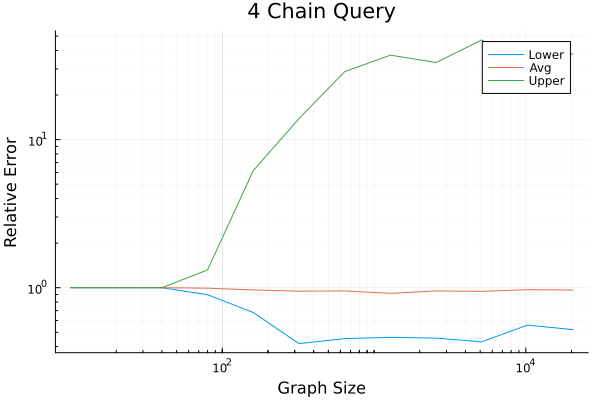

In [155]:
lower_bounds = max.(.1, [x[1] for x in bounds]./exact_sizes)
avg_bounds = [x[2] for x in bounds]./exact_sizes
upper_bounds = [x[3] for x in bounds]./exact_sizes
plot(graph_sizes, [lower_bounds avg_bounds upper_bounds], title="4 Chain Query", 
                label = ["Lower" "Avg" "Upper"], xlabel="Graph Size", ylabel = "Relative Error", 
                xscale=:log10, yscale=:log10, minorgrid=true)